## COVID Early Warning System Project Overview

Project goals, tools and techniques used, and data source info can be found [here](https://github.com/salvir1/covid-early-warning-system)

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
# df_state.info()

df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-06-01']

st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
# df_state.isna().sum() # No missing values!

df_state['raw_case_rate'] = df_state['positiveIncrease'] / df_state['Population'] * 100000 # normalize by population

In [3]:
def plot_shared_yscales(axs, x, ys, titles, state_):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(f'{state_} {title}')
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))

In [4]:
def plot_seasonal_decomposition(axs, series, sd, state_):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.resid, sd.seasonal],
                        ["Raw Series", "Trend Component $T_t$", "Residual Component $R_t$", "Seasonal Component $S_t$"],
                        state_)

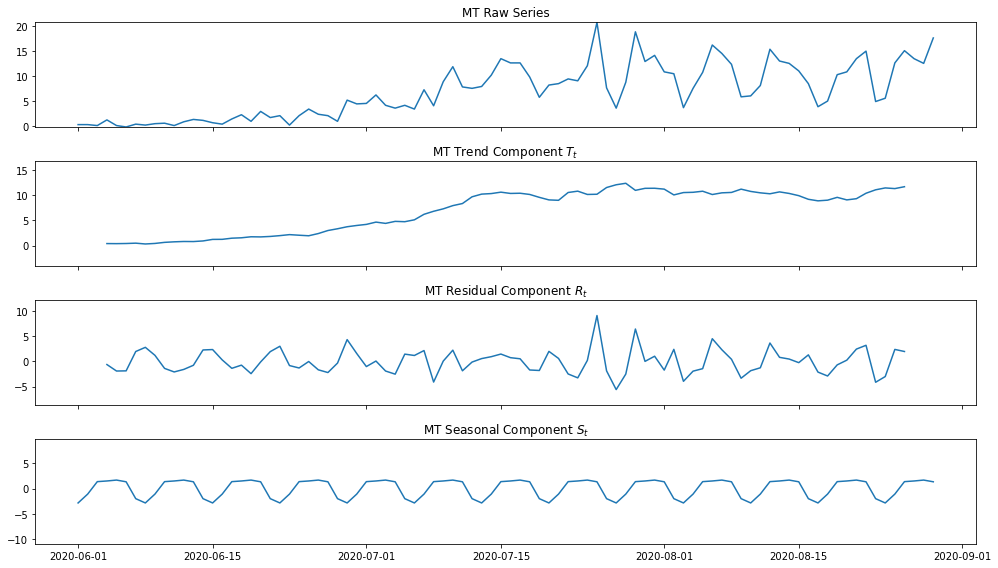

In [8]:
state_name = 'MT'
test_state = df_state[df_state['state']==state_name].set_index('date')
# Looking at decomposition through the summer
state_decomposition = sm.tsa.seasonal_decompose(test_state['raw_case_rate'].sort_index()[:90])
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, test_state['raw_case_rate'].sort_index()[:90], state_decomposition, state_name)
plt.tight_layout()

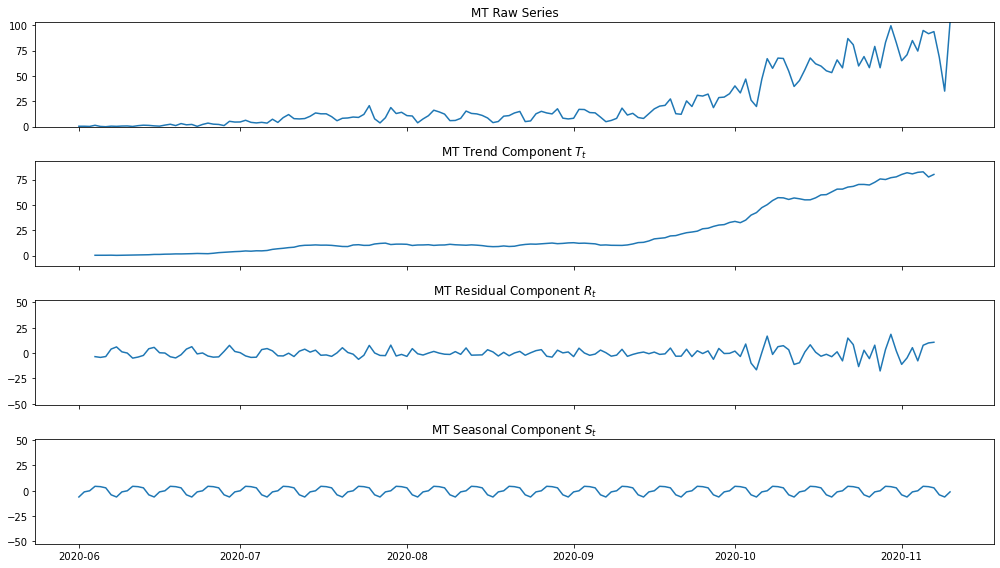

In [9]:
# Looking at decomposition up to current--note that residual compared to seasonal is much bigger
state_decomposition = sm.tsa.seasonal_decompose(test_state['raw_case_rate'].sort_index())
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, test_state['raw_case_rate'].sort_index(), state_decomposition, state_name)
plt.tight_layout()

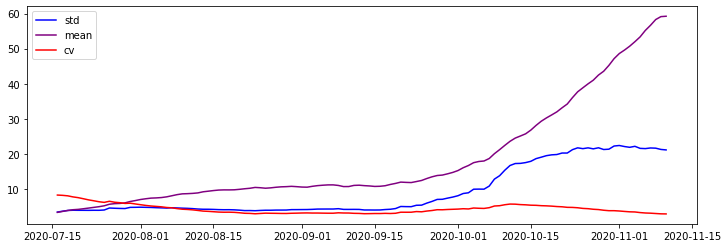

In [11]:
# The variabillity of the daily case rate doesn't look stable. How does it change over time? 
## Below is a trend of the standard deviation for the prior 45 days from the start of the data-set.
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_state.sort_index().index[45:],[test_state['raw_case_rate'].sort_index()[i:45+i].std() for i in range(len(test_state['raw_case_rate'])-45)], label='std', color='blue')
ax.plot(test_state.sort_index().index[45:],[test_state['raw_case_rate'].sort_index()[i:45+i].mean() for i in range(len(test_state['raw_case_rate'])-45)], label='mean', color='purple')
ax.plot(test_state.sort_index().index[45:],[test_state['raw_case_rate'].sort_index()[i:45+i].std() / test_state['raw_case_rate'].sort_index()[i:45+i].mean()*8 for i in range(len(test_state['raw_case_rate'])-45)], label='cv', color = 'red')
ax.legend()
fig.show()

In [ ]:
# Chart 2: Positivity and case trends for MT with threshholds

fig,ax = plt.subplots(1,2,figsize=(16,5))
fig.suptitle(f'COVID test positivity and positive cases by day for {chart_state_1}', size=15, y=1.05)
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')

ST_cvd = df_state[df_state['state'] == chart_state_1]
ST_cvd['positivity'] = ST_cvd['raw_case_rate'] / (ST_cvd['raw_case_rate']  + ST_cvd['negativeIncrease'] ) * 100
ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
ST_cvd = ST_cvd.sort_values('date', ascending=True)
ST_cvd['positivity_SMA'] = ST_cvd['positivity'].rolling(window=14).mean()

pos_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].std()
test_thresh = next(x for x, val in enumerate(ST_cvd['positivity_SMA']) if val > pos_upper_control_limit and x > 150)
pos_upper_control_limit

ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean()
case_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['raw_case_rate'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positiveIncrease'].std()

case_thresh = next(x for x, val in enumerate(ST_cvd['case_SMA_14']) if val > case_upper_control_limit and x > 150) 

ax[0].bar(ST_cvd['date'], ST_cvd['positivity'], label="positive test rate", alpha = 0.3)
ax[0].plot( ST_cvd['date'], ST_cvd['positivity_SMA'], label='12-day moving average')
ax[0].axhline(y=pos_upper_control_limit, ls= '--', lw=1, color = 'gray', label="mean + 2 std deviations", alpha=0.4)
ax[0].set_title(f"Positive test rate")
ax[0].set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
ax[0].set_ylim(0, 80)
ax[0].set_ylabel('Percent Positive')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].legend()

# print(ST_cvd['date'].iloc[res])
ax[1].bar(ST_cvd['date'], ST_cvd['raw_case_rate'], label="Diagnoses", alpha = 0.3)
ax[1].axhline(y=case_upper_control_limit, ls= '--', lw=1, color = 'gray', label="mean + 2 std deviations", alpha=0.4)
ax[1].axvline(x=ST_cvd['date'].iloc[case_thresh ], ls= '--', lw=1, color = 'red', label="cases cross threshhold", alpha=0.75)
ax[1].axvline(x=ST_cvd['date'].iloc[test_thresh], ls= '--', lw=1, color = 'orange', label="tests cross threshhold", alpha=0.75)
# ax[1].axvline(x=ST_cvd[ST_cvd['date']=='2020-09-28']['date'], ls= '--', lw=1, color = 'black', label="first public mention of uptick", alpha=0.75)
# ax[1].axvline(x=ST_cvd[ST_cvd['date']=='2020-10-03']['date'], ls= '--', lw=1, color = 'blue', label="MDs urge public to help", alpha=0.75)
ax[1].plot(ST_cvd['date'], 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift), label="Infections", color='green')
ax[1].plot(ST_cvd['date'], ST_cvd['case_SMA_14'], label="14-day moving average")
ax[1].set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
ax[1].set_title(f"Case rate")
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[1].set_ylim(0)
ax[1].set_ylabel('Positive cases')
ax[1].legend()
plt.savefig('img/COVID-infections-and-cases-for-MT-with-threshholds.png')

In [ ]:
# Chart 3-MT: Positivity and case trends for MT with threshholds and govt recognition

fig,ax = plt.subplots(figsize=(7,4))
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')

ST_cvd = df_state[df_state['state'] == chart_state_1]
ST_cvd['positivity'] = ST_cvd['raw_case_rate'] / (ST_cvd['raw_case_rate']  + ST_cvd['negativeIncrease'] ) * 100
ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
ST_cvd = ST_cvd.sort_values('date', ascending=True)
ST_cvd['positivity_SMA'] = ST_cvd['positivity'].rolling(window=14).mean()
pos_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].std()
test_thresh = next(x for x, val in enumerate(ST_cvd['positivity_SMA']) if val > pos_upper_control_limit and x > 150)

ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean()
case_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['raw_case_rate'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positiveIncrease'].std()
case_thresh = next(x for x, val in enumerate(ST_cvd['case_SMA_14']) if val > case_upper_control_limit and x > 150) 

ax.bar(ST_cvd['date'], ST_cvd['raw_case_rate'], label="diagnoses", alpha = 0.3)
ax.axhline(y=case_upper_control_limit, ls= '--', lw=1, color = 'gray', label="mean + 2 std deviations", alpha=0.4)
ax.axvline(x=ST_cvd['date'].iloc[case_thresh ], ls= '--', lw=1, color = 'red', label="cases cross threshhold", alpha=0.75)
ax.axvline(x=ST_cvd['date'].iloc[test_thresh], ls= '--', lw=1, color = 'orange', label="tests cross threshhold", alpha=0.75)
ax.axvline(x=ST_cvd[ST_cvd['date']=='2020-09-28']['date'], ls= '--', lw=1, color = 'black', label="first public mention of uptick", alpha=0.75)
ax.axvline(x=ST_cvd[ST_cvd['date']=='2020-10-03']['date'], ls= '--', lw=1, color = 'blue', label="MDs urge public to help", alpha=0.75)
ax.plot(ST_cvd['date'], 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift), label="new infections", color='green')
ax.plot(ST_cvd['date'], ST_cvd['case_SMA_14'], label="14-day moving average")
ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
ax.set_title(f"COVID trendlines, warning indicators, and public response for {chart_state_1}")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_ylim(0)
ax.set_ylabel('Positive cases')
ax.legend()
plt.savefig('img/COVID-infections-and-cases-for-MT-with-threshholds-and-response.png')

In [ ]:
# Chart 3-UT: Positivity and case trends for UT with threshholds and govt recognition

fig,ax = plt.subplots(figsize=(7,4))
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')

ST_cvd = df_state[df_state['state'] == chart_state_2]
ST_cvd['positivity'] = ST_cvd['raw_case_rate'] / (ST_cvd['raw_case_rate']  + ST_cvd['negativeIncrease'] ) * 100
ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
ST_cvd = ST_cvd.sort_values('date', ascending=True)
ST_cvd['positivity_SMA'] = ST_cvd['positivity'].rolling(window=14).mean()
pos_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].std()
test_thresh = next(x for x, val in enumerate(ST_cvd['positivity_SMA']) if val > pos_upper_control_limit and x > 150)

ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean()
case_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['raw_case_rate'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positiveIncrease'].std()
case_thresh = next(x for x, val in enumerate(ST_cvd['case_SMA_14']) if val > case_upper_control_limit and x > 150) 

ax.bar(ST_cvd['date'], ST_cvd['raw_case_rate'], label="diagnoses", alpha = 0.3)
ax.axhline(y=case_upper_control_limit, ls= '--', lw=1, color = 'gray', label="mean + 2 std deviations", alpha=0.4)
ax.axvline(x=ST_cvd['date'].iloc[case_thresh ], ls= '--', lw=1, color = 'red', label="cases cross threshhold", alpha=0.75)
ax.axvline(x=ST_cvd['date'].iloc[test_thresh], ls= '--', lw=1, color = 'orange', label="tests cross threshhold", alpha=0.75)
ax.axvline(x=ST_cvd[ST_cvd['date']=='2020-09-17']['date'], ls= '--', lw=1, color = 'black', label="state task force issues warning/action plan", alpha=0.75)
ax.plot(ST_cvd['date'], 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift), label="new infections", color='green')
ax.plot(ST_cvd['date'], ST_cvd['case_SMA_14'], label="14-day moving average")
ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
ax.set_title(f"COVID trendlines, warning indicators, and public response for {chart_state_2}")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_ylim(0)
ax.set_ylabel('Positive cases')
ax.legend()
plt.savefig('img/COVID-infections-and-cases-for-UT-with-threshholds-and-response.png')

In [ ]:
# Chart 3-WI: Positivity and case trends for WI with threshholds and govt recognition

fig,ax = plt.subplots(figsize=(7,4))
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')

ST_cvd = df_state[df_state['state'] == chart_state_3]
ST_cvd['positivity'] = ST_cvd['raw_case_rate'] / (ST_cvd['raw_case_rate']  + ST_cvd['negativeIncrease'] ) * 100
ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
ST_cvd = ST_cvd.sort_values('date', ascending=True)
ST_cvd['positivity_SMA'] = ST_cvd['positivity'].rolling(window=14).mean()
pos_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positivity'].std()
test_thresh = next(x for x, val in enumerate(ST_cvd['positivity_SMA']) if val > pos_upper_control_limit and x > 150)

ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean()
case_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['raw_case_rate'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['positiveIncrease'].std()
case_thresh = next(x for x, val in enumerate(ST_cvd['case_SMA_14']) if val > case_upper_control_limit and x > 150) 

ax.bar(ST_cvd['date'], ST_cvd['raw_case_rate'], label="diagnoses", alpha = 0.3)
ax.axhline(y=case_upper_control_limit, ls= '--', lw=1, color = 'gray', label="mean + 2 std deviations", alpha=0.4)
ax.axvline(x=ST_cvd['date'].iloc[case_thresh ], ls= '--', lw=1, color = 'red', label="cases cross threshhold", alpha=0.75)
ax.axvline(x=ST_cvd['date'].iloc[test_thresh], ls= '--', lw=1, color = 'orange', label="tests cross threshhold", alpha=0.75)
ax.axvline(x=ST_cvd[ST_cvd['date']=='2020-09-15']['date'], ls= '--', lw=1, color = 'black', label="governor and state MD issue warning/action plan", alpha=0.75)
ax.plot(ST_cvd['date'], 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift), label="new infections", color='green')
ax.plot(ST_cvd['date'], ST_cvd['case_SMA_14'], label="14-day moving average")
ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
ax.set_title(f"COVID trendlines, warning indicators, and public response for {chart_state_3}")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_ylim(0)
ax.set_ylabel('Positive cases')
ax.legend()
plt.savefig('img/COVID-infections-and-cases-for-WI-with-threshholds-and-response.png')

## An alternative approach based on random sampling

- Key metric, undiagnosed infection prevalence. An early indicator
- Many universities across the country have developed surveillance systems that rely upon daily random sampling of their students, faculty, and staff. 
- Can a similar random sampling surveillance system work at a regional level and not just in a closed population like a university?
- Such a system would face a number of logistical challenges, but would it be able to detect an outbreak as it is emerging and before it reaches the rapidly acceleration exponential phase?
- Would such a system give governments and public health experts a more accurate tool for managing the pandemic in their jurisdiction?

### Calculations and assumptions for a random sampling system

- A key question is how big the daily sample needs to be to detect a meaningful change in infection rate. The calculation requires a few steps.

- 1. **Calculate COVID prevalence.** COVID prevalence (the number of people actively infected with the disease) is  low. New diagnoses of COVID from testing programs fall into the range of  15 - 100 per 100,000 people per day. A ballpark estimate of diagnosed new infections is about 0.02% of the total susceptible population. The general literature typically states that the typical COVID infection runs about 10 days, meaning that the prevalence of diagnosed COVID cases in a susceptible population is about 0.2%. This number is an under-representation of the true prevalence since some people are asymptomatic and don't know to get tested, and others who are symptomatic choose to not get tested. It is hard to pin the size of these numbers down. Estimates range wildly. A recently published metastudy estimates the percent of asymptomatic infections to be about 20% (reference). Others who have compared the presence of antibodies with the known number of cases diagnosed suggest that as many as 9 in ten COVID infections go undiagnosed (reference). For the purposes of this analysis, it is assumed that about one-third of a population's COVID infections go undiagnosed. This would imply a prevalence of 0.3%.
 - 2. **Determine which population subset to draw the sample from.** Not everyone is equally likely to be infected by COVID. A surveillance system could be designed to take advantage of the fact that COVID is mainly transmitted from person to person through respiratory droplets, which means that a person's likelihood of acquiring and obtaining COVID increases the more one has close interaction with others. While less interactive people may ultimately be infected by someone who is more interactive, the continued spread of COVID depends on those who are highly interactive. A surveillance system could be set up to monitor people who are highly interactive including those who work in front line medicine (primary care, emergency medicine, hospital-based, nursing home-based); service industry workers (restaurant employees, grocery store front end employees, bartenders, hair stylists, those who work in salons, etc.); public safety (police, fire, EMS, airport); and younger people in general. COVID prevalence is likely to be higher in this group given that people in this group have more chances for infection. (This is especially true in the early stages of an outbreak before infections have a chance to be passed on to less interactive people). ((((( Interactivity in this group is many times higher than the rest of the population. Assume 3x as likely as general population. Make more robust.))))) This would imply overall prevalence in this population subset to be about 1%.
 
Link to WI website that shows spike in diagnoses among 18-24 preceded growth in cases across all ages across the state.
https://www.dhs.wisconsin.gov/covid-19/cases.htm#by%20age

### Version 1--Surveillance system utilizing PCR-based COVID testing

- PCR-based tests are the best tool for detecting COVID in the early stages of an infection

- A PCR-based surveillance system would be attempting to monitor active COVID infection prevalence--ideally early stage prevalence before people are likely to have sought a test. In other words, about 40% of total prevalence.
 

